In [1]:
from importlib import reload
from variaIa.variaIa import baserate

In [2]:
import pandas as pd

d = pd.read_csv('../Data/data_cheat.csv',
                sep=' ', index_col = 'CID')

import ipywidgets as ipw

su = ipw.Dropdown(options=['SDSS','SNLS','PS1','HST'],
                  description='Survey:',
                  value = 'SNLS')

colors = {'SDSS': 'lime',
          'SNLS': 'red',
          'PS1': 'blue',
          'HST': 'purple'} 

surv = {'SDSS': d[d['IDSURVEY'] == 1],
        'SNLS': d[d['IDSURVEY'] == 4],
        'PS1':  d[d['IDSURVEY'] == 15],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

def set_datap(su):
    global datap
    datap = np.sort(surv[su].zCMB.values)
    
int_datap = ipw.interactive(set_datap, su = su)
display(int_datap)

import numpy as np
import iminuit as im
from scipy.stats import poisson
from astropy.cosmology import Planck15 as cdata
import matplotlib.pyplot as plt
plt.style.use('classic')

interactive(children=(Dropdown(description='Survey:', index=1, options=('SDSS', 'SNLS', 'PS1', 'HST'), value='…

In [3]:
nb = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins:', continuous_update=False)

def set_bins(nb):
    global bins, bord, data
    bord = np.asarray(np.histogram(datap, bins = nb)[1])
    bins = np.asarray([[bord[i],bord[i+1]] for i in range(len(bord)-1)]).T
    data = np.histogram(datap, bord)[0]
    
int_bins = ipw.interactive(set_bins, nb = nb)
display(int_bins)

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins:', max=30, min=3), Outpu…

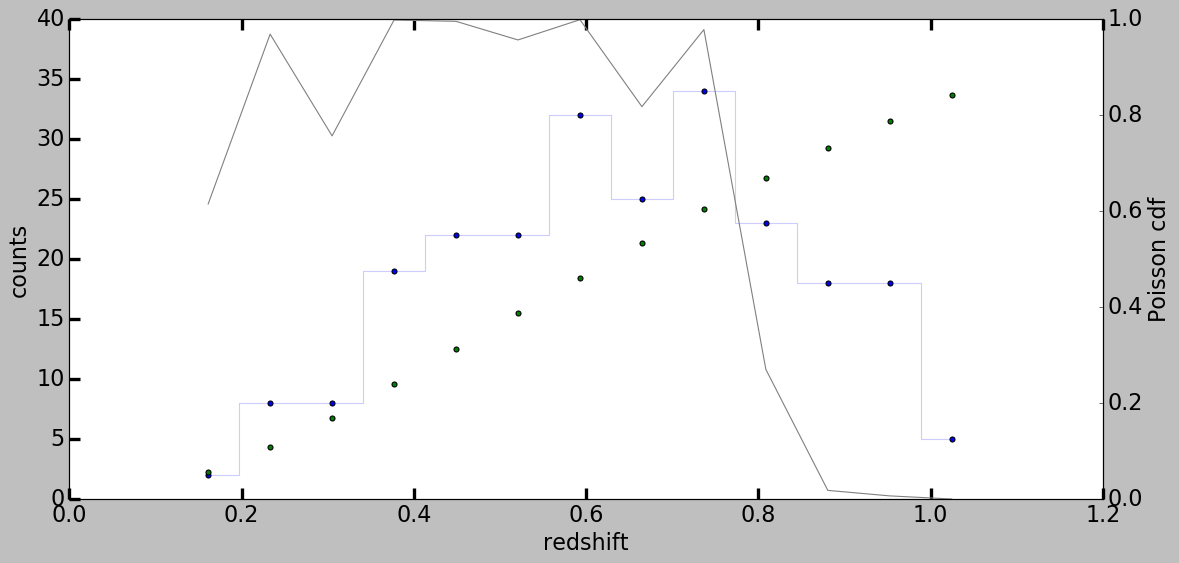

In [41]:
reload(baserate)

model = baserate.BaseRateModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(data, bins)
ratefitter.set_model(model)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.7)
ratefitter.fit(a_guess = 0.2)
_ = ratefitter.show(add_proba = True)

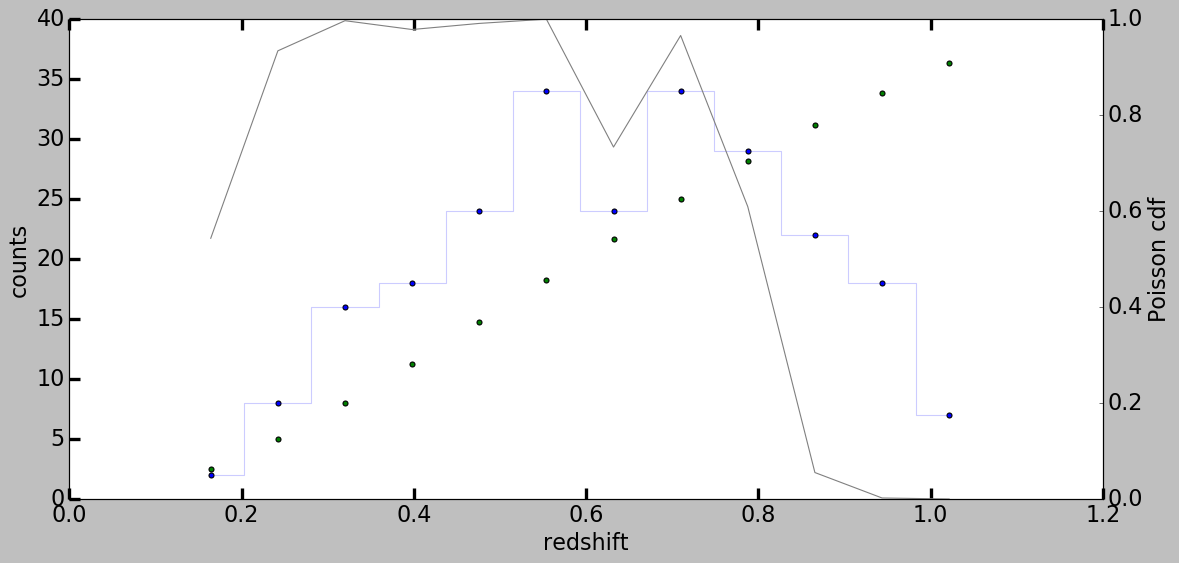

In [18]:
reload(baserate)

missed = baserate.ExpoRateModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(data, bins)
ratefitter.set_model(missed)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges < 0.7)
ratefitter.fit(a_guess = 0.2, b_guess = 1, zmax_guess = 0.7, zc_guess = 1e-1,\
               b_fixed = True, zmax_fixed = True, zc_fixed = True)
_ = ratefitter.show(add_proba = True)

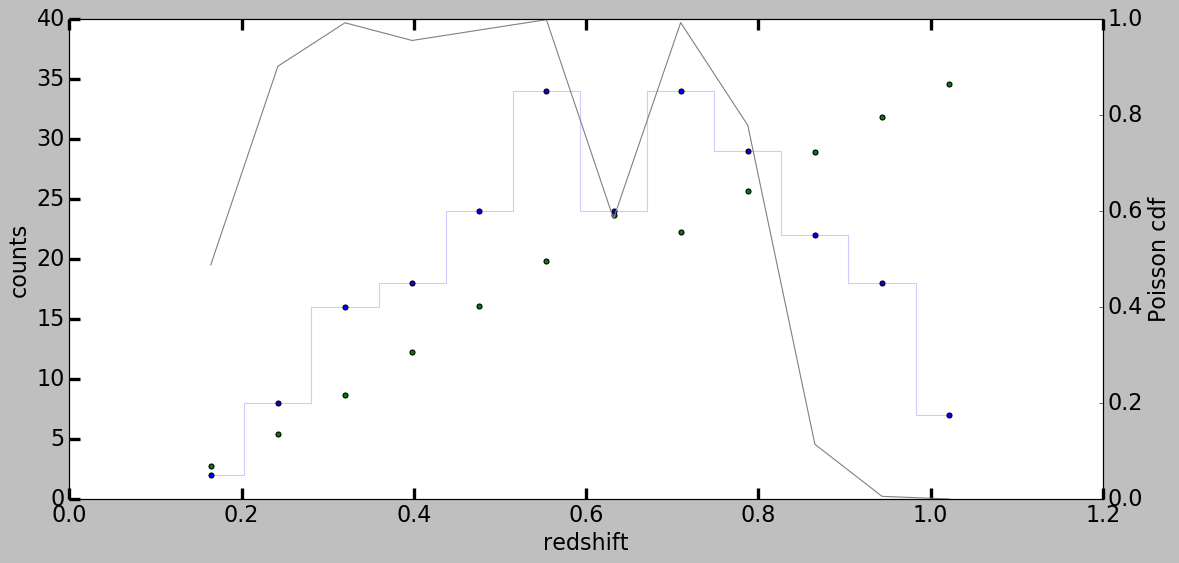

In [30]:
reload(baserate)

const = baserate.ConstRateModel()
ratefitter = baserate.RateFitter()
ratefitter.set_data(data, bins)
ratefitter.set_model(const)
#ratefitter.set_fitted_flag(ratefitter._central_redshiftranges<0.7)
ratefitter.fit(a_guess = 0.2, zmax_guess = 0.7,\
               zmax_fixed = True)
_ = ratefitter.show(add_proba = True)